In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as kr
from keras import layers as layer
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [3]:
#? Data Generator
data = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

train_gen = data.flow_from_directory('../dataImages/',
                                              target_size=(28,28),
                                              subset='training')

val_gen = data.flow_from_directory('../dataImages/',
                                            target_size=(28,28),
                                            subset='validation')

Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


In [4]:
#? Model
def create_model(filters1=64, filters2=128, filters3=256, kernel_size=(3,3), learning_rate=1e-3):
    entry = layer.Input(shape=(28, 28, 3))
    x = layer.SeparableConv2D(filters1, kernel_size, activation='relu')(entry)
    x = layer.MaxPooling2D((2, 2))(x)
    x = layer.SeparableConv2D(filters2, kernel_size, activation='relu')(x)
    x = layer.MaxPooling2D((2, 2))(x)
    x = layer.SeparableConv2D(filters3, (2, 2), activation='relu')(x)
    x = layer.GlobalMaxPooling2D()(x)
    x = layer.Dense(256)(x)
    x = layer.LeakyReLU()(x)
    x = layer.Dense(64, kernel_regularizer=l2(2e-4))(x)
    x = layer.LeakyReLU()(x)
    output = layer.Dense(26, activation='softmax')(x)

    model = Model(inputs=entry, outputs=output)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [5]:
kr.clear_session()

chkpt = ModelCheckpoint('BrailleClassification.h5',save_best_only=True)
rlr = ReduceLROnPlateau(patience=8,verbose=0)
early_stop = EarlyStopping(patience=15,verbose=1)

# First Test

In [6]:
model = create_model(filters1=64, filters2=128, filters3=256, kernel_size=(3,3), learning_rate=1e-3)
history = model.fit_generator(train_gen,
                              validation_data=val_gen,
                              epochs=500,
                              callbacks=[chkpt,rlr,early_stop],
                              verbose=1)

C:\Users\raizer blade\AppData\Local\Temp\ipykernel_13292\3413739260.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/500
39/39 [==============================] - 13s 269ms/step - loss: 3.2775 - accuracy: 0.0553 - val_loss: 3.2255 - val_accuracy: 0.0833 - lr: 0.0010
Epoch 2/500
39/39 [==============================] - 2s 53ms/step - loss: 3.1214 - accuracy: 0.1250 - val_loss: 2.8279 - val_accuracy: 0.1859 - lr: 0.0010
Epoch 3/500
39/39 [==============================] - 2s 48ms/step - loss: 2.6526 - accuracy: 0.2380 - val_loss: 2.5106 - val_accuracy: 0.3109 - lr: 0.0010
Epoch 4/500
39/39 [==============================] - 2s 49ms/step - loss: 2.2001 - accuracy: 0.3598 - val_loss: 1.8101 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 5/500
39/39 [==============================] - 2s 51ms/step - loss: 1.8314 - accuracy: 0.4599 - val_loss: 1.6112 - val_accuracy: 0.4840 - lr: 0.0010
Epoch 6/500
39/39 [==============================] - 2s 48ms/step - loss: 1.5198 - accuracy: 0.5737 - val_loss: 1.4546 - val_accuracy: 0.5609 - lr: 0.0010
Epoch 7/500
39/39 [==============================] - 2s 54ms/step - 

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d (Separable  (None, 26, 26, 64)       283       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 11, 11, 128)      8896      
 leConv2D)                                                       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                         

In [8]:
model = load_model('BrailleClassification.h5')
acc = model.evaluate_generator(val_gen)[1]
print('model accuracy: {}'.format(round(acc,4)))

C:\Users\raizer blade\AppData\Local\Temp\ipykernel_13292\1787143949.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val_gen)[1]


model accuracy: 0.9615


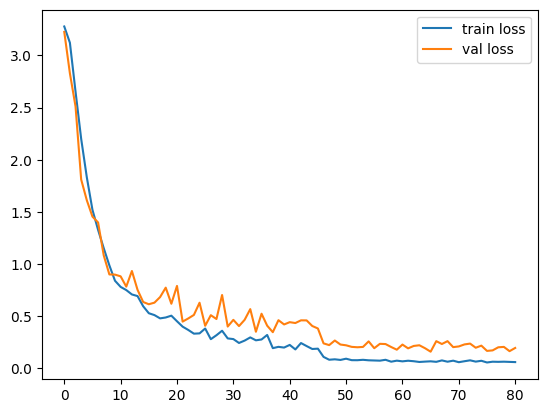

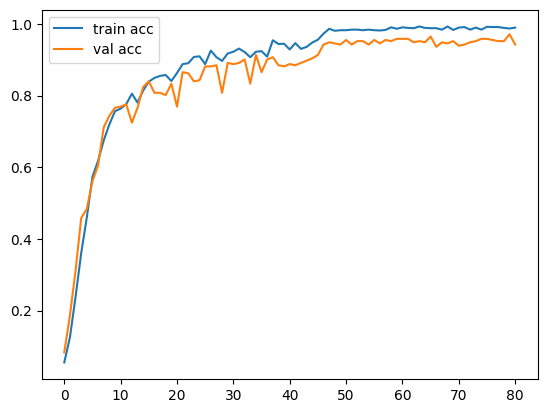

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [10]:
pred = model.predict(val_gen)
pred

10/10 [==============================] - 1s 38ms/step


array([[3.88859128e-17, 2.13195008e-18, 9.83218091e-14, ...,
        8.16058887e-11, 1.83336021e-18, 1.74085157e-09],
       [5.08910125e-05, 1.05301745e-09, 1.77352479e-12, ...,
        1.75004518e-21, 1.01147879e-34, 1.76650093e-14],
       [5.81902040e-13, 1.73429196e-12, 1.35533810e-13, ...,
        5.75356687e-08, 1.08165177e-18, 1.21709149e-04],
       ...,
       [9.75367942e-31, 3.28528914e-12, 9.33320695e-13, ...,
        0.00000000e+00, 0.00000000e+00, 8.59006910e-25],
       [7.06764840e-05, 9.83644545e-01, 2.01242510e-03, ...,
        2.34883022e-13, 2.15427726e-17, 1.15433629e-09],
       [1.22132365e-17, 7.24613105e-14, 2.28464294e-16, ...,
        5.82197702e-13, 1.53599229e-15, 2.01393141e-06]], dtype=float32)

[[[255. 255. 255.]
  [249. 249. 249.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [242. 242. 242.]
  [255. 255. 255.]
  ...
  [254. 254. 254.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[245. 245. 245.]
  [241. 241. 241.]
  [247. 247. 247.]
  ...
  [249. 249. 249.]
  [254. 254. 254.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [254. 254. 254.]
  [249. 249. 249.]
  ...
  [247. 247. 247.]
  [254. 254. 254.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [253. 253. 253.]
  ...
  [254. 254. 254.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[252. 252. 252.]
  [253. 253. 253.]
  [254. 254. 254.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]
(28, 28, 3)
1/1 [==============================] - 0s 24ms/step
[1]


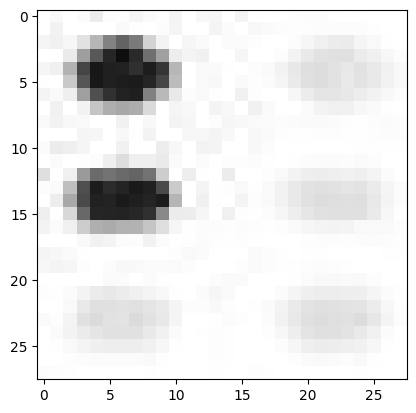

In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np
img=image.load_img('../Braille Dataset/Braille Dataset/b1.JPG11whs.jpg')

plt.imshow(img)

x=image.img_to_array(img)
print(x)

print(x.shape)

x=np.expand_dims(x,axis=0)
model.predict(x)

b=np.argmax(model.predict(x), axis=1)
print(b)

# Second Test

In [15]:
model = create_model(filters1=64, filters2=128, filters3=256, kernel_size=(5,5), learning_rate=1e-3)
history = model.fit_generator(train_gen,
                              validation_data=val_gen,
                              epochs=500,
                              callbacks=[chkpt,rlr,early_stop],
                              verbose=1)

Epoch 1/500


C:\Users\raizer blade\AppData\Local\Temp\ipykernel_13292\1141570434.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


39/39 [==============================] - 8s 151ms/step - loss: 3.2684 - accuracy: 0.0481 - val_loss: 3.1836 - val_accuracy: 0.0545 - lr: 0.0010
Epoch 2/500
39/39 [==============================] - 3s 71ms/step - loss: 2.8488 - accuracy: 0.1611 - val_loss: 2.3209 - val_accuracy: 0.3045 - lr: 0.0010
Epoch 3/500
39/39 [==============================] - 3s 72ms/step - loss: 2.0557 - accuracy: 0.4079 - val_loss: 1.7465 - val_accuracy: 0.5032 - lr: 0.0010
Epoch 4/500
39/39 [==============================] - 3s 74ms/step - loss: 1.4891 - accuracy: 0.5657 - val_loss: 1.3291 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 5/500
39/39 [==============================] - 3s 74ms/step - loss: 1.1925 - accuracy: 0.6627 - val_loss: 0.9423 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 6/500
39/39 [==============================] - 3s 74ms/step - loss: 0.9378 - accuracy: 0.7404 - val_loss: 0.8369 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 7/500
39/39 [==============================] - 3s 69ms/step - loss: 0.7729 

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d_3 (Separab  (None, 24, 24, 64)       331       
 leConv2D)                                                       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 separable_conv2d_4 (Separab  (None, 8, 8, 128)        9920      
 leConv2D)                                                       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                       

In [17]:
model = load_model('BrailleClassification.h5')
acc = model.evaluate_generator(val_gen)[1]
print('model accuracy: {}'.format(round(acc,4)))

C:\Users\raizer blade\AppData\Local\Temp\ipykernel_13292\1787143949.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val_gen)[1]


model accuracy: 0.9647


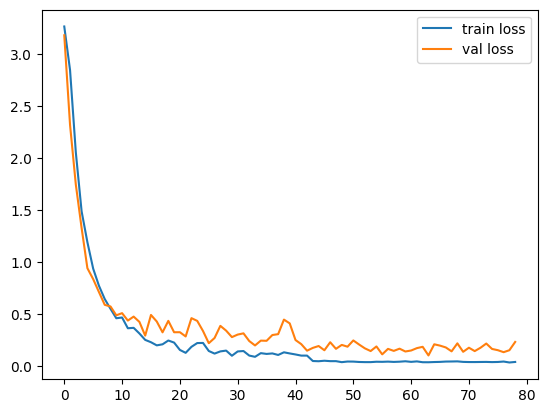

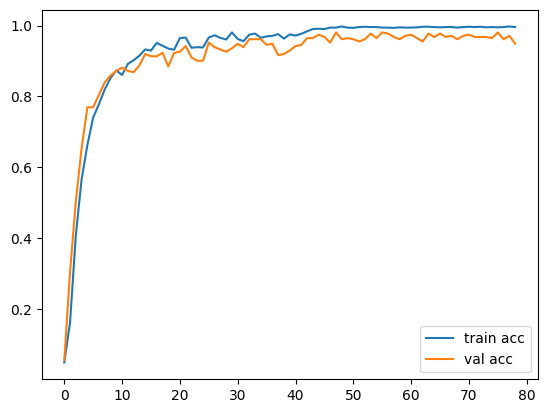

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


# Third Test

In [20]:
model = create_model(filters1=64, filters2=256, filters3=256, kernel_size=(3,3), learning_rate=1e-3)
history = model.fit_generator(train_gen,
                              validation_data=val_gen,
                              epochs=500,
                              callbacks=[chkpt,rlr,early_stop],
                              verbose=1)

Epoch 1/500


C:\Users\raizer blade\AppData\Local\Temp\ipykernel_13292\3756014199.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


39/39 [==============================] - 5s 59ms/step - loss: 3.2835 - accuracy: 0.0321 - val_loss: 3.2610 - val_accuracy: 0.0385 - lr: 0.0010
Epoch 2/500
39/39 [==============================] - 2s 52ms/step - loss: 3.1988 - accuracy: 0.0681 - val_loss: 2.9463 - val_accuracy: 0.1346 - lr: 0.0010
Epoch 3/500
39/39 [==============================] - 2s 52ms/step - loss: 2.7431 - accuracy: 0.1971 - val_loss: 2.3829 - val_accuracy: 0.2949 - lr: 0.0010
Epoch 4/500
39/39 [==============================] - 2s 50ms/step - loss: 2.0228 - accuracy: 0.4335 - val_loss: 1.6427 - val_accuracy: 0.5545 - lr: 0.0010
Epoch 5/500
39/39 [==============================] - 2s 50ms/step - loss: 1.4337 - accuracy: 0.6002 - val_loss: 1.1751 - val_accuracy: 0.6635 - lr: 0.0010
Epoch 6/500
39/39 [==============================] - 2s 49ms/step - loss: 1.1358 - accuracy: 0.6819 - val_loss: 1.0088 - val_accuracy: 0.7276 - lr: 0.0010
Epoch 7/500
39/39 [==============================] - 2s 51ms/step - loss: 1.0134 -

In [21]:
model = load_model('BrailleClassification.h5')
acc = model.evaluate_generator(val_gen)[1]
print('model accuracy: {}'.format(round(acc,4)))

C:\Users\raizer blade\AppData\Local\Temp\ipykernel_13292\1787143949.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val_gen)[1]


model accuracy: 0.9583


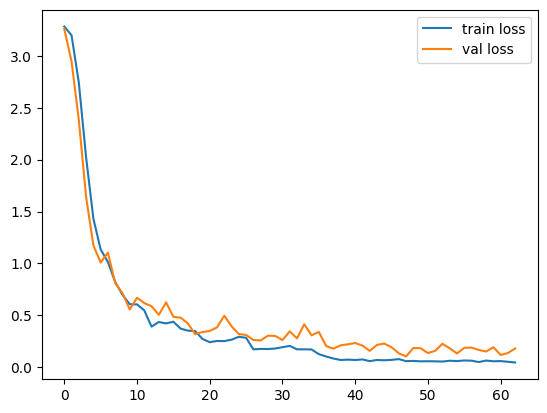

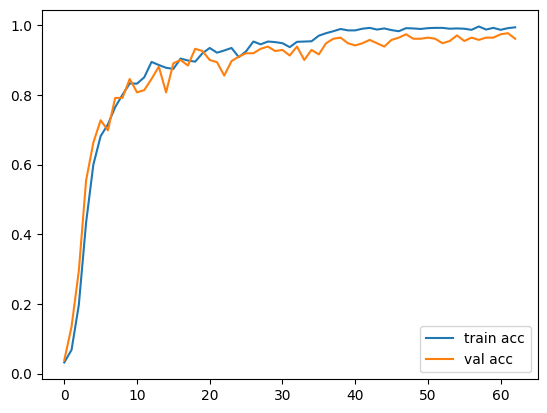

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Fourth Test

In [23]:
model = create_model(filters1=64, filters2=128, filters3=128, kernel_size=(3,3), learning_rate=1e-3)
history = model.fit_generator(train_gen,
                              validation_data=val_gen,
                              epochs=500,
                              callbacks=[chkpt,rlr,early_stop],
                              verbose=1)

Epoch 1/500


C:\Users\raizer blade\AppData\Local\Temp\ipykernel_13292\4264284140.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


39/39 [==============================] - 5s 56ms/step - loss: 3.2853 - accuracy: 0.0465 - val_loss: 3.2582 - val_accuracy: 0.0897 - lr: 0.0010
Epoch 2/500
39/39 [==============================] - 2s 48ms/step - loss: 3.2185 - accuracy: 0.0729 - val_loss: 3.0902 - val_accuracy: 0.1506 - lr: 0.0010
Epoch 3/500
39/39 [==============================] - 2s 48ms/step - loss: 2.8085 - accuracy: 0.1851 - val_loss: 2.3225 - val_accuracy: 0.2949 - lr: 0.0010
Epoch 4/500
39/39 [==============================] - 2s 46ms/step - loss: 2.2284 - accuracy: 0.3542 - val_loss: 2.0159 - val_accuracy: 0.3878 - lr: 0.0010
Epoch 5/500
39/39 [==============================] - 2s 47ms/step - loss: 1.9248 - accuracy: 0.4223 - val_loss: 1.7125 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 6/500
39/39 [==============================] - 2s 49ms/step - loss: 1.6118 - accuracy: 0.5112 - val_loss: 1.6005 - val_accuracy: 0.5256 - lr: 0.0010
Epoch 7/500
39/39 [==============================] - 2s 48ms/step - loss: 1.4086 -

In [24]:
model = load_model('BrailleClassification.h5')
acc = model.evaluate_generator(val_gen)[1]
print('model accuracy: {}'.format(round(acc,4)))

C:\Users\raizer blade\AppData\Local\Temp\ipykernel_13292\1787143949.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val_gen)[1]


model accuracy: 0.9712


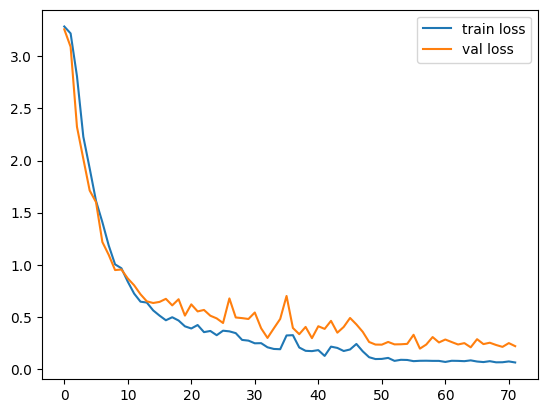

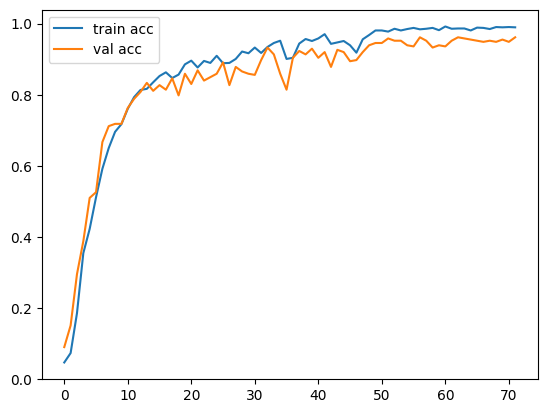

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()